<a href="https://colab.research.google.com/github/raian621/FinalProjectNLP/blob/main/Copy_of_FinalProjectNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary-Based Sentiment Analysis

## CSCE 4290 - Introduction to Natural Language Processing

- Ryan Bell
- Farouq Siwoku

**Contents**
1. [Introduction](#scrollTo=NyWwimvyPOTi)
  - [1.1 Problem](#scrollTo=IzaaYyYzRAvB)
  - [1.2 Importance](#scrollTo=0aopY4JIRE6x)
  - [1.3 Dataset](#scrollTo=X7IAZFhXSmZH)
  - [1.4 Proposed Methodology](#scrollTo=efdTl80eRHmm)
  - [1.5 Project Management](#scrollTo=BblVXk1DSXbk)
2. [Implementation](#scrollTo=sY3kog91Q3az)
  - [2.1 Exploratory Data Analysis](#scrollTo=rmvhO7ncSbYr)
  - [2.2 Sentiment Analysis on Entire Passages](#scrollTo=TKJSjIK2OzMr)
    - [2.2.1 Aggregate Bag of Words](#scrollTo=opEbHPEJOMrn)
  - [2.3 Sentiment Analysis on Summaries](#scrollTo=RSm_uKq6QYiI)
    - [2.3.1 Summary Feature Engineering](#scrollTo=W_rR079PQ3Zf)
    - [2.3.2 Summarized Bag of Words](#scrollTo=laz-aTE3OfEK)
3. [Results](#scrollTo=H7TLZ7lIPUng)
4. [Conclusion](#scrollTo=MrV4glZJQ61_)



## 1. Introduction

### 1.1 Problem

What is the problem we want to solve, and a hypothesis
- PERFORMANCE: Improve the performance of sentiment analysis
- HYPOTHESIS: Maybe using a summary instead of the entire text for sentiment analysis will improve the accuracy of ML model's performance.

### 1.2 Importance

- Model could be used to predict the sentiment of news stories about a stock
- Model could also be used to predict the general opinion on a product or move made by a company
- Using summaries may result in a smaller corpora, and thus bag-of-words models may consume less memory
- etc.

### 1.3 Dataset

Explain the source of the dataset, how it was compiled, the features in the dataset, what features we're planning to use, etc.

We're using the Yelp dataset from Kaggle https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_review.json. or https://www.yelp.com/dataset.

The Yelp dataset contains 6,990,280 user reviews of businesses. We will only use the text content and the star rating of each review. We will perform summarization on the text of each review as a form of feature extraction and also use a bag-of-words model to extract features from the text. The star rating of each review is the target that we will try to predict, which consists of 5 classes corresponding to the amount of stars each review was given on Yelp's site.

### 1.4 Proposed Methodology

Write about what models we'll use, what combination of solutions (sentiment analysis and summarization in this case) we'll employ, what features we'll use, and what kind of cross validation / train test split we'll utilize.

models:
- Summarization:
  - Some Generative Pre-trained Transformer (GPT) model(s)
  - Maybe a naive summary of just the set of the most common $N$ words?
- Sentiment Analysis:
  - Bag of Words:
    - Naive Bayes
    - Logistic Regression
  - Word Embeddings
    - Some Bidirectional Encoder Representations from Transformer (BERT) model(s)

Summary -> Sentiment Analysis = Better Accuracy?

### Validation

We will use 5-fold cross validation to test our hypothesis that sentiment analysis on a summarized piece of text predicts the sentiment more accurately than simply performing sentiment analysis on entire text.

### Summarization

Pegasus model :::: ? Generates abstractive summaries using a transformer architecture? We will use Google's Pegasus model to generate a summary of each review as a form of feature extraction.

### Sentiment Analysis

We will use Naive Bayes, Decision Tree, and Logistic regression models with a bag-of-words representation of each entry in the corpora and also a variant of the BERT model to perform sentiment analysis on each review.

### 1.5 Project Management


Explain how the project was organized I guess. The rubric isn't clear on what this means

## 2. Implementation

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install  transformers sentencepiece torch tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# imports and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')
tqdm.pandas()

# pytorch
import torch
TORCH_DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# constants
ALL_REVIEWS_JSON_PATH = 'yelp_academic_dataset_review.json'
SOME_REVIEWS_CSV_PATH = 'yelp_reviews.csv'
SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH = 'yelp_reviews_with_summaries.csv'
TARGET_REVIEW_COUNT = 10000 # only use a relatively small subset of the almost 7 million reviews

# results dataframe
RESULTS = pd.DataFrame(columns=['F1-Score', 'Precision', 'Recall', 'Accuracy', 'Time to Train', 'Time to Test'])
RESULTS

,F1-Score,Precision,Recall,Accuracy,Time to Train,Time to Test


In [4]:
from os import path

df = pd.DataFrame()

if not path.exists(SOME_REVIEWS_CSV_PATH) and not path.exists(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH):
    chunks = []
    with open(ALL_REVIEWS_JSON_PATH, 'rb') as file:
        reader = pd.read_json(file, orient='records', lines=True, dtype={
            'stars': np.int64,
            'useful': np.int8,
            'funny': np.int8,
            'cool': np.int8
        }, chunksize=1000)

        for chunk in tqdm(reader, total=6991):
            reduced_chunk = chunk.drop(columns=['review_id', 'user_id', 'useful','funny', 'cool', 'business_id', 'date'])
            chunks.append(reduced_chunk)

    df = pd.concat(chunks, ignore_index=True)
    df['text'] = df['text'].apply(lambda x: x.replace('\r', ' '))
    del chunks

In [5]:
if not df.empty:
    star_counts = df['stars'].value_counts().sort_index()
    print(star_counts)

    ax = star_counts.plot(
        kind='bar',
        title='Count of Reviews by Stars'
    )
    ax.set_xlabel('Review Stars')
    ax.set_ylabel('Count')
    plt.show()

In [6]:
if not df.empty:
    groups = df.groupby(['stars'], as_index=True)
    counts = {rating:groups.count()['text'][rating] for rating in range(1, 6)}
    total_count = df.shape[0]
    frequencies = {rating:(count/total_count) for rating, count in counts.items()}
    sampled_counts = {}

    review_count = 0
    for rating, count in counts.items():
        sampled_counts[rating] = TARGET_REVIEW_COUNT // 5
        review_count += sampled_counts[rating]

    remainder = TARGET_REVIEW_COUNT - review_count

    for rating in np.random.randint(low=1, high=6, size=remainder):
        sampled_counts[rating] += 1

    df_sampled = []
    for rating, count in sampled_counts.items():
        df_sampled.append(groups.get_group((rating,)).sample(count))

    df = pd.concat(df_sampled, ignore_index=True)
    df.to_csv(SOME_REVIEWS_CSV_PATH, index=False)

    ax = df['stars'].value_counts().sort_index().plot(
        kind='bar',
        title='Count of Reviews by Stars'
    )
    ax.set_xlabel('Review Stars')
    ax.set_ylabel('Count')
    plt.show()

In [7]:
if df.empty and not path.exists(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH):
    df = pd.read_csv(SOME_REVIEWS_CSV_PATH)

    ax = df['stars'].value_counts().sort_index().plot(
        kind='bar',
        title='Count of Reviews by Stars'
    )
    ax.set_xlabel('Review Stars')
    ax.set_ylabel('Count')
    plt.show()

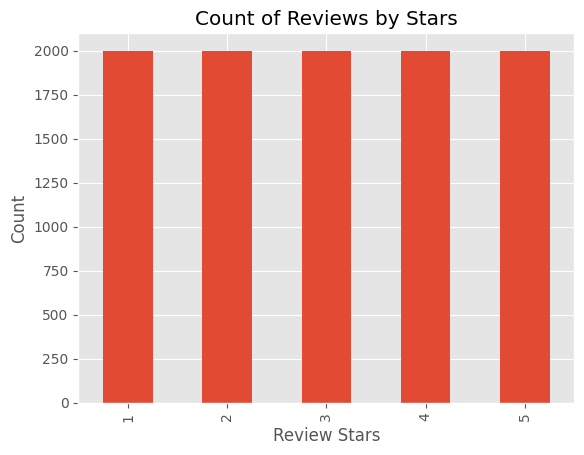

In [8]:
if df.empty:
    df = pd.read_csv(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH, skipinitialspace=True)

    ax = df['stars'].value_counts().sort_index().plot(
        kind='bar',
        title='Count of Reviews by Stars'
    )
    ax.set_xlabel('Review Stars')
    ax.set_ylabel('Count')
    plt.show()

### 2.1 Exploratory Data Analysis

Load the dataset and make some fancy graphs.

### 2.2 Sentiment Analysis on Entire Passages

In [9]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
)

def get_metrics(y_target, y_pred):
  return {
    'f1-score': f1_score(y_target, y_pred, average='macro'),
    'precision': precision_score(y_target, y_pred, average='macro'),
    'recall': recall_score(y_target, y_pred, average='macro'),
    'accuracy': accuracy_score(y_target, y_pred)
  }, confusion_matrix(y_target, y_pred)


def print_results(scores, confusion_matrix, times):
  print('Training time:', times[0])
  print('Testing  time:', times[1])

  print('\nf1-score: ', scores['f1-score'])
  print('precision:', scores['precision'])
  print('recall:   ', scores['recall'])
  print('accuracy: ', scores['accuracy'])

  if confusion_matrix:
    cm = confusion_matrix[0]
    plt.figure(figsize=(9,9))
    sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      linewidths=.5,
      square=True,
      cmap='Blues_r',
      xticklabels=[1, 2, 3, 4, 5],
      yticklabels=[1, 2, 3, 4, 5],
    )
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Accuracy Score: {0}'.format(scores['accuracy'])
    plt.title(title, size=15)


def record_results(scores, times, approach):
    global RESULTS
    RESULTS = pd.concat([
        RESULTS,
        pd.DataFrame({
            'F1-Score': scores['f1-score'],
            'Precision': scores['precision'],
            'Recall': scores['recall'],
            'Accuracy': scores['accuracy'],
            'Time to Train': times[0],
            'Time to Test': times[1],
        }, [approach])
    ])


#### 2.2.1 Aggregate Bag of Words

In [10]:
# TARGET_REVIEW_COUNT = 100

# groups = df.groupby(['stars'], as_index=True)
# counts = {rating:groups.count()['text'][rating] for rating in range(1, 6)}
# total_count = df.shape[0]
# frequencies = {rating:(count/total_count) for rating, count in counts.items()}
# sampled_counts = {}

# review_count = 0
# for rating, count in counts.items():
#     sampled_counts[rating] = TARGET_REVIEW_COUNT // 5
#     review_count += sampled_counts[rating]

# remainder = TARGET_REVIEW_COUNT - review_count

# for rating in np.random.randint(low=1, high=6, size=remainder):
#     sampled_counts[rating] += 1

# df_sampled = []
# for rating, count in sampled_counts.items():
#     df_sampled.append(groups.get_group((rating,)).sample(count))

# df = pd.concat(df_sampled, ignore_index=True)
# # df.to_csv(SOME_REVIEWS_CSV_PATH, index=False)

# ax = df['stars'].value_counts().sort_index().plot(
#     kind='bar',
#     title='Count of Reviews by Stars'
# )
# ax.set_xlabel('Review Stars')
# ax.set_ylabel('Count')
# plt.show()

In [11]:
X, y = df.drop(columns=['stars']), df['stars']

In [12]:
from sklearn.model_selection import train_test_split

train_idx, test_idx, _, _ = train_test_split(
    np.arange(0, len(X)), y, stratify=y, shuffle=True, test_size=0.2
)

X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]

In [13]:
X_train

,text,summary
8802,Honeygrow is convenient and delicious! The sta...,Honeygrow is convenient and delicious!<n>The s...
9144,Honestly one of the best pizzas I've had in a ...,My wife ordered the cheesy garlic bread and it...
1803,"Fucking sucks. I live on main street, everyone...","I live on main street, everyone sucks, needs m..."
8763,I've been to Maggiano's numerous times through...,"Maggiano's is a great option, especially for l..."
2036,I've only ordered take out twice here. Servic...,"Service here is horrible. Food is average, cal..."
...,...,...
2904,"So disappointed, I have ordered a food that I ...",Carnitas burrito was really bad. Although it w...
9562,The phone screen they fixed for me stopped wor...,They fixed my broken phone screen for free.<n>...
5237,Drop in training classes with Igor. Call to ch...,Drop in training classes with Igor. Call to ch...
7872,The bartender was very welcoming & helped me p...,The albondigas taco had great flavor- jus a we...


In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

en_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     ryadmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     ryadmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
import string
import re

stemmer = PorterStemmer()

def remove_urls(text):
    return re.sub(r"http(s?)://[\S]+", '', text)

def remove_numbers(text):
    return re.sub(r' \d ', ' ', text)

def remove_punctuation(text):
    text = re.sub(f'[!.?\n]', ' ', text)
    return re.sub(f'[{string.punctuation}]', '', text)

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = []
    for word in words:
        lowercase = stemmer.stem(word.lower().strip())
        if word not in en_stopwords:
            filtered_words.append(lowercase)

    return ' '.join(filtered_words)


def clean_text(text):
    text = remove_urls(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)

    return text

review = df.iloc[20]['text']
print('Original:')
print('------------')
print(review)
review = clean_text(review)
print('\nCleaned:')
print('------------')
print(review)

Original:
------------
Worst food I've had in years! Warm water and cold food. Told the waiter and he brought out some more cold fries. Worse $25 spent!

Cleaned:
------------
worst food ive year warm water cold food told waiter brought cold fri wors 25 spent


In [16]:
def train_bow_model(model, bow_train, y_train):
    model.fit(bow_train, y_train)

def evaluate_bow_model(model, bow_test, y_test):
    y_pred = model.predict(bow_test)
    return get_metrics(y_test, y_pred)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

print('cleaning training text')
X_train['clean_text'] = X_train['text'].progress_apply(clean_text)
print('cleaning testing text')
X_test['clean_text'] = X_test['text'].progress_apply(clean_text)

cv = CountVectorizer()
bow_train = cv.fit_transform(X_train['text'])
bow_test = cv.transform(X_test['text'])

cleaning training text


  0%|          | 0/8000 [00:00<?, ?it/s]

cleaning testing text


  0%|          | 0/2000 [00:00<?, ?it/s]

Training time: 0.00863027572631836
Testing  time: 0.010834217071533203

f1-score:  0.5025631526965869
precision: 0.5204655402233381
recall:    0.499
accuracy:  0.499


/tmp/ipykernel_1650/783456723.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS = pd.concat([


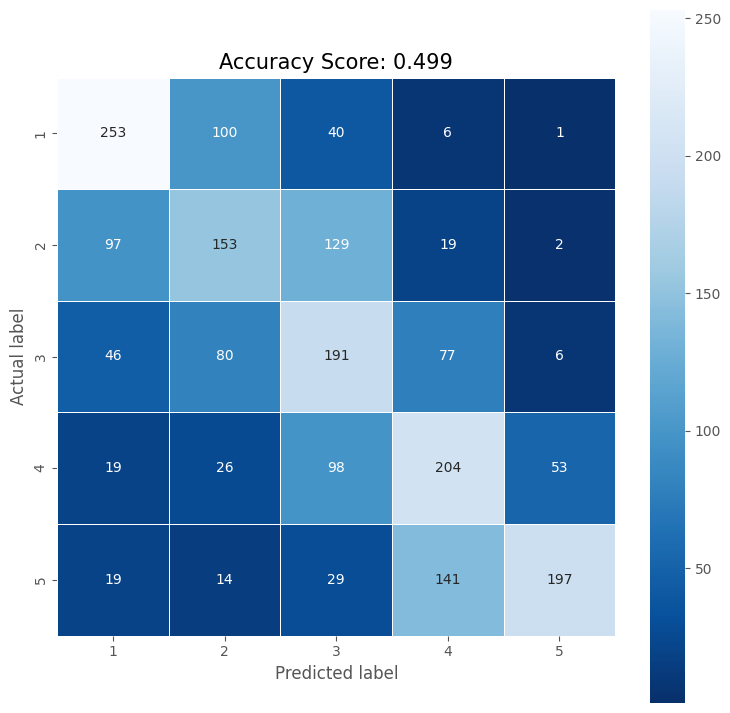

In [18]:
from sklearn.naive_bayes import MultinomialNB
import time

nb = MultinomialNB()

start = time.time()
train_bow_model(nb, bow_train, y_train)
train_time = time.time() - start

start = time.time()
scores, cm = evaluate_bow_model(nb, bow_test, y_test)
test_time = time.time() - start
# train_time, test_time = times
# train_time += bow_train_time
# test_time += bow_test_time

times = (train_time, test_time)

print_results(scores, (cm,), times)
record_results(scores, times, 'Naive Bayes')

/opt/tljh/user/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 8.17408037185669
Testing  time: 0.021757841110229492

f1-score:  0.5206726173485287
precision: 0.5183122001435463
recall:    0.5245
accuracy:  0.5245


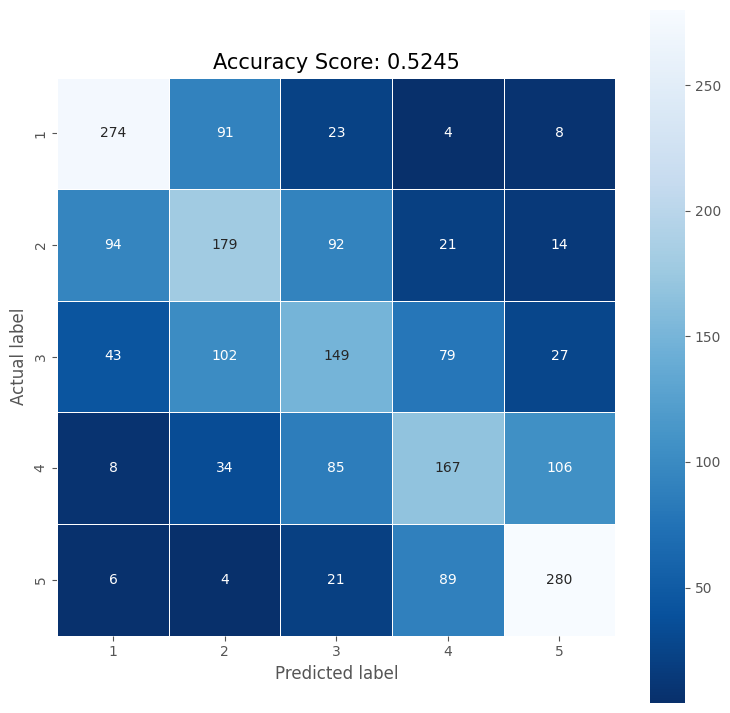

In [19]:
from sklearn.linear_model import LogisticRegression

lgc = LogisticRegression()
start = time.time()
train_bow_model(lgc, bow_train, y_train)
train_time = time.time() - start

start = time.time()
scores, cm = evaluate_bow_model(lgc, bow_test, y_test)
test_time = time.time() - start

times = (train_time, test_time)

print_results(scores, (cm,), (train_time, test_time))
record_results(scores, times, 'Logistic Regression')

In [20]:
from transformers import AutoModel, AutoTokenizer
from torch import nn
import torch

class BertReviewStarClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential()
        self.classifier.dropout = nn.Dropout(p=0.3)
        self.classifier.linear = nn.Linear(in_features=768, out_features=5)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
        x = self.classifier(x)
        return x

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def make_word_embedding_dataset(texts, labels):
    all_input_ids = []
    all_attn_masks = []
    
    for text in tqdm(texts, total=len(texts)):
      encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
      )
    
      all_input_ids.append(encoded['input_ids'])
      all_attn_masks.append(encoded['attention_mask'])
    
    all_input_ids = torch.cat(all_input_ids, dim=0)
    all_attn_masks = torch.cat(all_attn_masks, dim=0)
    all_labels = torch.tensor(labels.values-1)

    return TensorDataset(all_input_ids, all_attn_masks, all_labels)

In [22]:
from torch.optim import AdamW

@torch.compile()
def train(model, optimizer, train_dataloader, criterion, train_loss_history=None):    
    model.train()
    epoch_loss = 0

    for batch in tqdm(train_dataloader, total=len(train_dataloader), desc='Training...'):
        optimizer.zero_grad()
        input_ids = batch[0].to(TORCH_DEVICE)
        attention_mask = batch[1].to(TORCH_DEVICE)
        labels = batch[2].to(TORCH_DEVICE)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if train_loss_history != None:
            train_loss_history.append(loss.item())

    print(f'Training loss: {epoch_loss/len(train_dataloader)}')


@torch.compile()
def evaluate(model, test_dataloader, test_dataset, criterion, test_loss_history=None):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader), desc='Evaluating...'):
            input_ids = batch[0].to(TORCH_DEVICE)
            attention_mask = batch[1].to(TORCH_DEVICE)
            labels = batch[2].to(TORCH_DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item() / len(predictions)
            if test_loss_history != None:
                test_loss_history.append(loss.item())

    print(f'Test loss: {total_loss/len(test_dataloader)} Test acc: {total_acc/len(test_dataloader)*100}%')


def train_model(model, epochs, X_train, X_test, y_train, y_test, loss_history=None):
    train_loss_history = loss_history[0] if loss_history else None
    test_loss_history = loss_history[1] if loss_history else None
    
    print('generating word embeddings for training set...')
    start = time.time()
    train_dataset = make_word_embedding_dataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    train_time = time.time() - start

    start = time.time()
    print('generating word embeddings for testing set...')
    test_dataset = make_word_embedding_dataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=8)
    test_time = time.time() - start
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    for epoch in range(epochs):
        print(f'\n============== Epoch {epoch+1} / {epochs} ==============')
        start = time.time()
        train(model, optimizer, train_dataloader, criterion, train_loss_history)
        train_time += time.time() - start

        start = time.time()
        evaluate(model, test_dataloader, test_dataset, criterion, test_loss_history)
        test_time += time.time() - start

    return train_time, test_time

In [23]:
TORCH_DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'bert-base-uncased'

model = BertReviewStarClassifier(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = torch.compile(model)
model.to(TORCH_DEVICE) # send model to the GPU if available

model

OptimizedModule(
  (_orig_mod): BertReviewStarClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [24]:
y.dtype

dtype('int64')

In [ ]:
train_loss_history, test_loss_history = [], []

train_time, _ = train_model(model, 4, X_train['text'], X_test['text'], y_train, y_test, (train_loss_history, test_loss_history))

generating word embeddings for training set...


  0%|          | 0/8000 [00:00<?, ?it/s]

generating word embeddings for testing set...


  0%|          | 0/2000 [00:00<?, ?it/s]


============== Epoch 1 / 4 ==============


Training...:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/tljh/user/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:140: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


In [ ]:
model.eval()

def predict_sentiment(text):
  tokens = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length', return_attention_mask=True).to(TORCH_DEVICE)
  result = model(tokens['input_ids'], tokens['attention_mask'])
  return int(torch.argmax(result))+1

start = time.time()
y_pred = X_test['text'].progress_apply(predict_sentiment)
test_time = time.time() - start

In [ ]:
scores, cm = get_metrics(y_test, y_pred)

print_results(scores, (cm,), (train_time, test_time))
record_results(scores, (train_time, test_time), 'Fine Tuned BERT')

### 2.2 Sentiment Analysis on Summaries

Generate a bag of words representative of the entire corpus:

#### 2.3.1 Summary Feature Engineering

Generate the summaries for each passage of text that we can use as a "summarized" corpora

Import Libraries

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

Summary Generation Function

In [ ]:
def generate_summary(text, tokenizer, model):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=1024,
        truncation=True,
        padding="max_length",
    ).to(TORCH_DEVICE)
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=150,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
if not path.exists(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH):
    model_ckpt = "google/pegasus-cnn_dailymail"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
    model = torch.compile(model)
    model.to(TORCH_DEVICE)

    # generate summaries
    df["summary"] = df["text"].progress_apply(
        lambda x: generate_summary(x, tokenizer, model)
    )

    df.to_csv(SOME_REVIEWS_WITH_SUMMARIES_CSV_PATH, index=False)
    X, y = df.drop(columns=['stars']), df['stars']
    X_train, X_test, y_train, y_test = X.loc[train_idx], X.loc[test_idx], y.loc[train_idx], y.loc[test_idx]

Analyzing the Summaries

Visualization

In [ ]:
# Calculate the length of the original texts and their summaries
df['original_length'] = df['text'].progress_apply(lambda x: len(x.split(' ')))
df['summary_length'] = df['summary'].progress_apply(lambda x: len(x.split(' ')))
df['word_count_removed'] = df['original_length'] - df['summary_length']

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
ax[0].set_title('Distribution of Original Text Word Counts')
sns.histplot(df['original_length'], ax=ax[0])
ax[1].set_title('Distribution of Summary Word Counts')
sns.histplot(df['summary_length'], ax=ax[1])
ax[2].set_title('Distribution of Removed Word Counts')
sns.histplot(df['word_count_removed'], ax=ax[2])
plt.tight_layout()
plt.show()

#### 2.3.2 Summarized Bag of Words

In [ ]:
print('cleaning training summaries')
X_train['clean_summary'] = X_train['summary'].progress_apply(clean_text)
print('cleaning testing text')
X_test['clean_summary'] = X_test['summary'].progress_apply(clean_text)

cv = CountVectorizer()
bow_train = cv.fit_transform(X_train['summary'])
bow_test = cv.transform(X_test['summary'])

In [ ]:
nb2 = MultinomialNB()
start = time.time()
train_bow_model(nb2, bow_train, y_train)
train_time = time.time() - start

start = time.time()
scores, cm = evaluate_bow_model(nb2, bow_test, y_test)
test_time = time.time() - start

times = (train_time, test_time)

print_results(scores, (cm,), (train_time, test_time))
record_results(scores, times, 'Naive Bayes on Summaries')

In [ ]:
lgc = LogisticRegression()
start = time.time()
train_bow_model(lgc, bow_train, y_train)
train_time = time.time() - start

start = time.time()
scores, cm = evaluate_bow_model(lgc, bow_test, y_test)
test_time = time.time() - start

times = (train_time, test_time)

print_results(scores, (cm,), (train_time, test_time))
record_results(scores, times, 'Logistic Regression on Summaries')

In [ ]:
model = BertReviewStarClassifier(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = torch.compile(model)
model.to(TORCH_DEVICE) # send model to the GPU if available

model

In [ ]:
train_loss_history, test_loss_history = [], []

train_time, _ = train_model(model, 4, X_train['summary'], X_test['summary'], y_train, y_test, (train_loss_history, test_loss_history))

In [ ]:
start = time.time()
y_pred = X_test['summary'].progress_apply(predict_sentiment)
test_time = time.time() - start
scores, cm = get_metrics(y_test, y_pred)

print_results(scores, (cm,), (train_time, test_time))
record_results(scores, (train_time, test_time), 'Fine-Tuned BERT on Summaries')

## 3. Results

Show the final metrics for each model / combination of models

In [ ]:
RESULTS

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

ax[0].set_title('F1-Score by Approach')
ax[1].set_xscale('log')
sns.barplot(RESULTS, y=RESULTS.index, x='F1-Score', orient='h', ax=ax[0], hue=RESULTS.index, palette='Accent')

ax[1].set_title('Time to Train by Approach (Logarithmic Scale)')
sns.barplot(RESULTS, y=RESULTS.index, x='Time to Train', orient='h', hue=RESULTS.index, ax=ax[1], palette='Accent')
ax[1].set_xscale('log')
ax[1].set_xlabel('Time to Train (seconds)')

ax[2].set_title('Time to Test by Approach (Logarithmic Scale)')
sns.barplot(RESULTS, y=RESULTS.index, x='Time to Test', orient='h', hue=RESULTS.index, ax=ax[2], palette='Accent')
ax[2].set_xscale('log')
ax[2].set_xlabel('Time to Test (seconds)')

plt.tight_layout()
plt.show()

## 4. Conclusion


Conclude with a conclusion in the concluding paragraph